In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# intializing theta and beta numpy arrays with the given data in degrees
theta = np.array([0.0,30.0,60.0,90.0,120.0,150.0])
beta = np.array([59.96,56.42,44.10,25.72,-0.27,-34.29])

# converting to radians
theta = theta * np.pi/180
beta = beta * np.pi/180

# d(beta)/dt in rad/s
theta_der = 1

In [3]:
# we create a function, cubic_spline, to get the values of the coefficeients of the interpolating polynomials of each interval
# these are n+1 points and we need to interpolate it in n intervals

# we first determine the second derivatives of the splines in each interval,
# which allows us to find the splines and only requires us to solve n-1 simulataneous equations,
# a major improvement over 4n equations in the standard approach

def DD_calculator(x,y):

  # number of intervals is 1 less than the number of points
  n = x.size - 1
  # initialize empty matrix Z and empty vector Y, to solve the system of linear equations , Y = ZD, where D is the vector
  # containing the second derivatives of the function at the knots
  Z = np.zeros((n+1,n+1))
  Y = np.zeros((n+1,1))

  # Generatethe Z matrix and the vector Y
  for i in range(1,n):
    Z[i,i-1] = x[i]-x[i-1]
    Z[i,i] = 2*(x[i+1]-x[i-1])
    Z[i,i+1] = x[i+1]-x[i]

    Y[i,0] = 6*(y[i+1]-y[i])/(x[i+1]-x[i]) + 6*(y[i-1]-y[i])/(x[i]-x[i-1])

  Y[0,0] = 0
  Y[n,0] = 0
  Z[0,0] = 1
  Z[n,n] = 1

  # as Y = ZD, we have, D = Z⁻¹Y
  DD = np.linalg.inv(Z) @ Y

  return DD

# this function generates the values of the spline in a given interval
def interval_y_generator_cubic(xl,xr,yl,yr,DDl,DDr):
  x = np.linspace(xl,xr,num=100,endpoint=True)

  return (DDl * ((xr-x)**3)/(6*(xr-xl))+
          DDr * ((x-xl)**3)/(6*(xr-xl))+
          (yl/(xr-xl) - DDl *(xr-xl)/6)*(xr-x)+
          (yr/(xr-xl) - DDr *(xr-xl)/6)*(x-xl))

# the complete cubic spline function
def cubic_spline(x,y,DD):
  n = x.size - 1
  plt.grid()
  plt.title('β v/s θ plot')
  plt.xlabel('θ (in radians)')
  plt.ylabel('β (in radians)')
  for i in range(1,n+1):
    xl = x[i-1]
    xr = x[i]
    X = np.linspace(xl,xr,num=100,endpoint=True)
    Y = interval_y_generator_cubic(xl,xr,y[i-1],y[i],DD[i-1],DD[i])
    plt.plot(X,Y,'r')


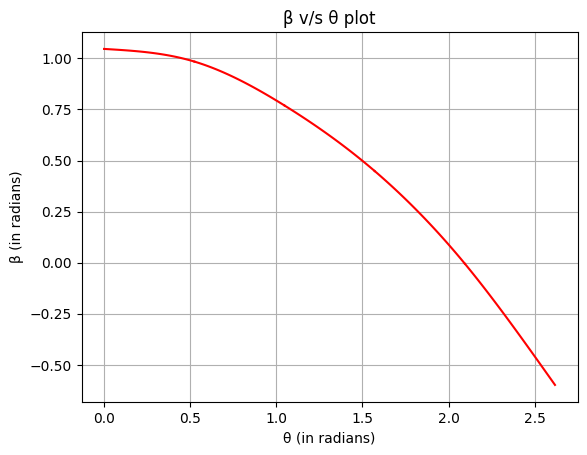

In [4]:
# plotting commands within the function cubic_spline
cubic_spline(theta,beta,DD_calculator(theta,beta))

In [5]:
# this function is the derivative of the cubic spline in a given interval
# note that we are actually calculating dβ/dθ, but as dθ/dt = 1 radian/sec,
# magnitude-wise the values are same
def interval_y_generator_cubic_der(xl,xr,yl,yr,DDl,DDr):
  x = np.linspace(xl,xr,num=100,endpoint=True)
  return (-(DDl*(3*(xr-x)**2)/(6*(xr-xl)))+
          (DDr*(3*(x-xl)**2)/(6*(xr-xl)))-
          (yl/(xr-xl) - DDl *(xr-xl)/6)+
          (yr/(xr-xl) - DDr *(xr-xl)/6))*theta_der

# the complete cubic spline derivative function
def cubic_spline_der(x,y,DD):
  # empty array for values of derivative of beta at tabulated points
  beta_der_table_values = []

  n = x.size - 1
  plt.grid()
  plt.title('dβ/dt v/s θ plot')
  plt.xlabel('θ (in radians)')
  plt.ylabel('dβ/dt (in radians/sec)')
  for i in range(1,n+1):
    xl = x[i-1]
    xr = x[i]
    X = np.linspace(xl,xr,num=100,endpoint=True)
    Y = interval_y_generator_cubic_der(xl,xr,y[i-1],y[i],DD[i-1],DD[i])
    if(len(beta_der_table_values)==0):beta_der_table_values.append(Y[0])
    beta_der_table_values.append(Y[-1])
    plt.plot(X,Y,'r')
  return beta_der_table_values

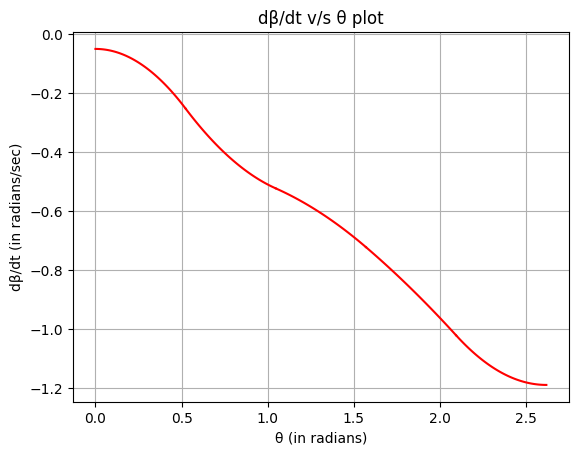

In [6]:
# plotting dβ/dt v/s θ
beta_der_table_values = cubic_spline_der(theta,beta,DD_calculator(theta,beta))

In [7]:
# printing table of dβ/dt values
d = {'θ (in radians)':theta,'dβ/dt (in radians/sec)':beta_der_table_values}
df = pd.DataFrame(d)
print(df)

   θ (in radians)  dβ/dt (in radians/sec)
0        0.000000               -0.050506
1        0.523599               -0.252989
2        1.047198               -0.523539
3        1.570796               -0.722855
4        2.094395               -1.022041
5        2.617994               -1.189979
